# Prediksi Emosi Spotify dengan Random Forest
- Target: valence > 0.5 → 1 (Positif), else 0 (Netral)
- Fitur: Hanya atribut audio (tanpa valence!)
- Model: Random Forest
- Evaluasi: Akurasi realistis, tanpa data leakage

# Import Library

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visual settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 10

# Baca Dataset

In [31]:
df_spotify = pd.read_csv('Spotify Song Attributes.csv')

# Drop Kolom Tidak Relevan

In [32]:
# Hapus kolom identitas
df_spotify = df_spotify.drop(columns=[col for col in ["Unnamed: 0", "id", "song_title", "artist"] if col in df_spotify.columns])
df_spotify.columns = df_spotify.columns.str.strip()

# Hapus baris tanpa valence
df_spotify = df_spotify.dropna(subset=['valence'])

print("✅ Dataset dimuat dan dibersihkan.")
print(f"Jumlah lagu: {len(df_spotify)}")

✅ Dataset dimuat dan dibersihkan.
Jumlah lagu: 2017


# ✨ Visualisasi 1: Distribusi Valence

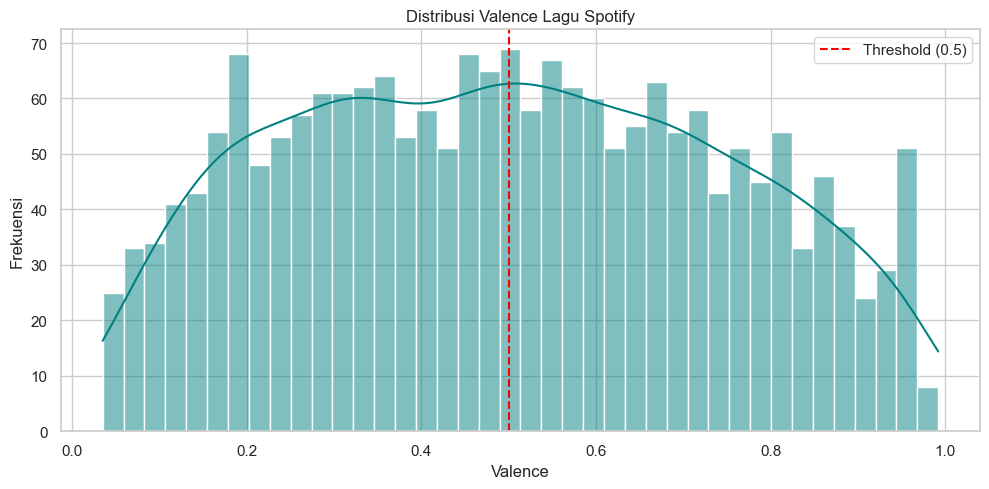

In [33]:
plt.figure(figsize=(10, 5))
sns.histplot(df_spotify['valence'], bins=40, kde=True, color='teal')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title('Distribusi Valence Lagu Spotify')
plt.xlabel('Valence')
plt.ylabel('Frekuensi')
plt.legend()
plt.tight_layout()
plt.show()

# Buat Target dan HAPUS Valence

In [34]:
# Buat target biner
df_spotify['target'] = (df_spotify['valence'] > 0.5).astype(int)

# 🔥 HAPUS valence — ini kunci untuk menghindari data leakage!
df_spotify = df_spotify.drop(columns=['valence'])

# Verifikasi
assert 'valence' not in df_spotify.columns, "❌ valence masih ada di dataset!"
print("✅ valence berhasil dihapus dari fitur.")
print(f"Fitur yang digunakan: {len(df_spotify.columns) - 1} fitur")

✅ valence berhasil dihapus dari fitur.
Fitur yang digunakan: 12 fitur


# ✨ Visualisasi 2: Distribusi Target

C:\Users\user\AppData\Local\Temp\ipykernel_16716\2322901264.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=df_spotify, palette=['#ff9999', '#66b3ff'])


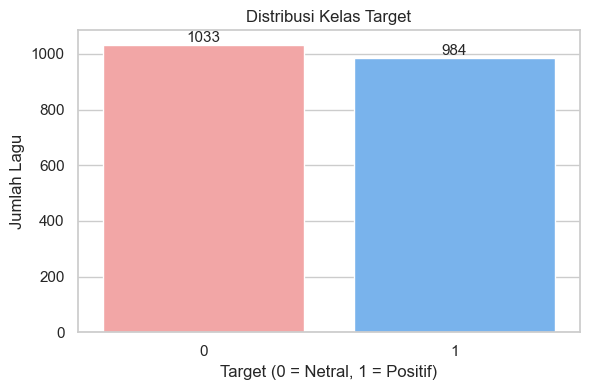

In [35]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='target', data=df_spotify, palette=['#ff9999', '#66b3ff'])
plt.title('Distribusi Kelas Target')
plt.xlabel('Target (0 = Netral, 1 = Positif)')
plt.ylabel('Jumlah Lagu')
# Tambahkan angka di atas batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

# ✨ Visualisasi 3: Heatmap Korelasi

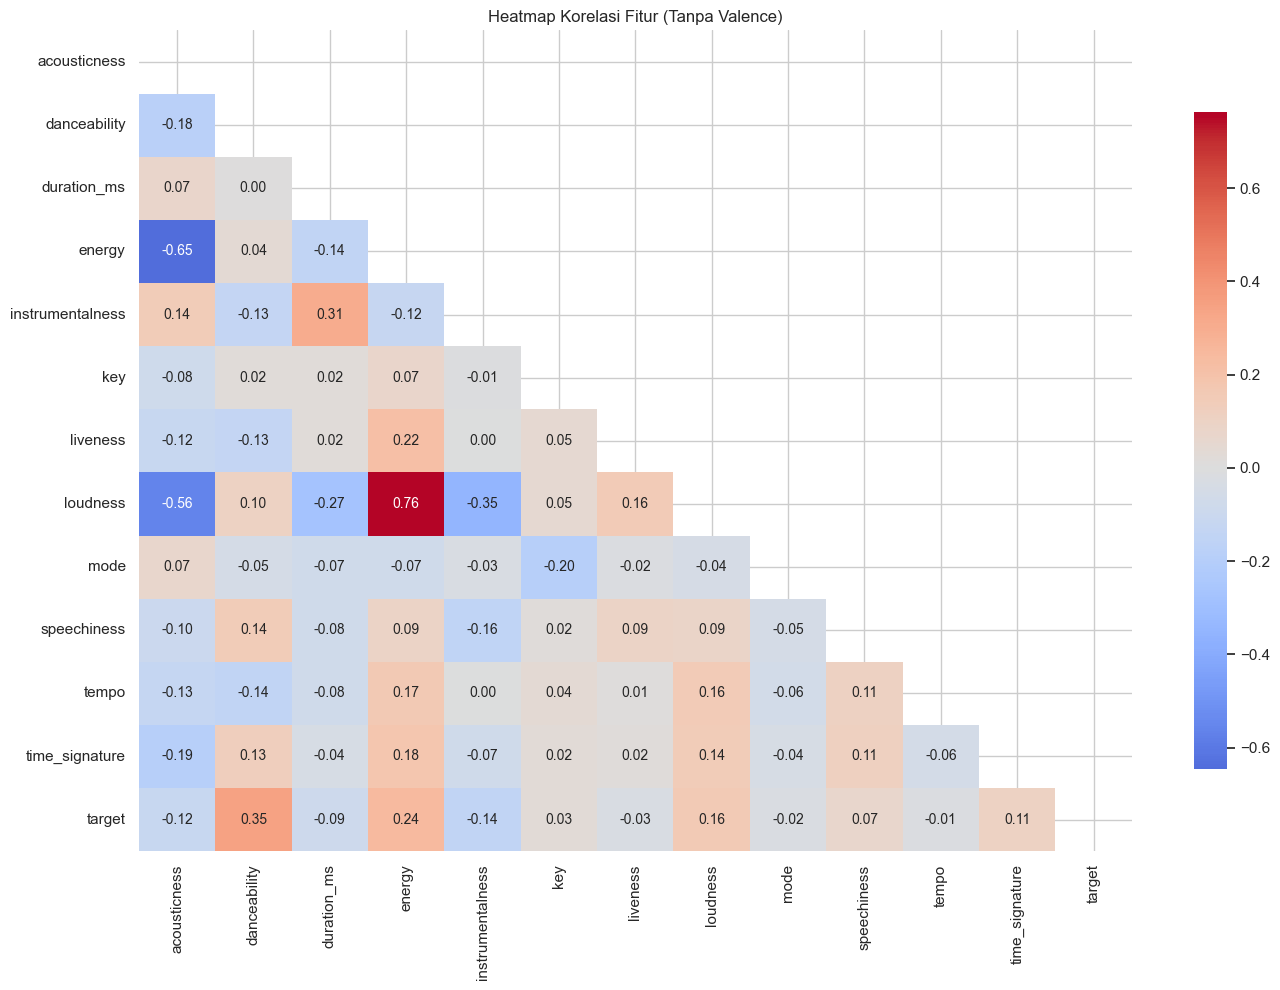

In [36]:
plt.figure(figsize=(14, 10))
corr = df_spotify.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap="coolwarm", center=0, cbar_kws={"shrink": .8})
plt.title("Heatmap Korelasi Fitur (Tanpa Valence)")
plt.tight_layout()
plt.show()

# Siapkan Fitur dan Target

In [37]:
X = df_spotify.drop("target", axis=1)
y = df_spotify["target"]

print("Fitur yang digunakan:")
print(X.columns.tolist())

Fitur yang digunakan:
['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature']


# Split Data

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (1613, 12)
Test shape: (404, 12)


# Latih Model Random Forest

In [39]:
spotify_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42
)

spotify_model.fit(X_train, y_train)
print("✅ Model berhasil dilatih.")

✅ Model berhasil dilatih.


# ✨ Visualisasi 4: Confusion Matrix

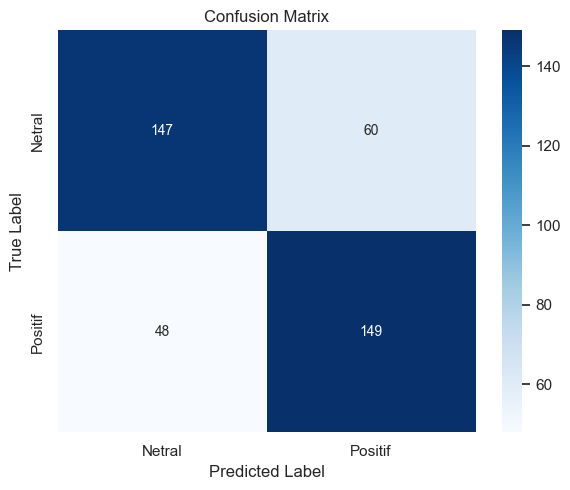

In [40]:
y_pred = spotify_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Netral', 'Positif'],
            yticklabels=['Netral', 'Positif'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Evaluasi Model

In [41]:
accuracy = accuracy_score(y_test, y_pred)
print("🎯 METRIK EVALUASI")
print(f"Accuracy: {accuracy:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Netral", "Positif"]))

🎯 METRIK EVALUASI
Accuracy: 0.7327

📋 Classification Report:
              precision    recall  f1-score   support

      Netral       0.75      0.71      0.73       207
     Positif       0.71      0.76      0.73       197

    accuracy                           0.73       404
   macro avg       0.73      0.73      0.73       404
weighted avg       0.73      0.73      0.73       404



# Simpan Model dan Daftar Fitur

In [42]:
# Simpan model
with open("model_random_forest.pkl", "wb") as file:
    pickle.dump(spotify_model, file)

# Simpan daftar fitur (penting untuk Flask)
with open("rf_feature_columns.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

print("✅ Artefak berhasil disimpan:")
print("  - Model Spotify RF.pkl")
print("  - rf_feature_columns.pkl")

✅ Artefak berhasil disimpan:
  - Model Spotify RF.pkl
  - rf_feature_columns.pkl
